In [1]:
import pandas as pd
import numpy as np
train_df=pd.read_csv("yds_train2018.csv")
test_df=pd.read_csv("yds_test2018.csv")
expence_df=pd.read_csv("promotional_expense.csv")

In [3]:
def initial_processing():
    print(train_df["Country"].unique())
    print(train_df.info())
    print(test_df.info())
    print(expence_df.info())
    print(train_df.head())
    print(test_df.head())
    print(expence_df.head())
initial_processing()

['Argentina' 'Belgium' 'Columbia' 'Denmark' 'England' 'Finland']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79072 entries, 0 to 79071
Data columns (total 8 columns):
S_No           79072 non-null int64
Year           79072 non-null int64
Month          79072 non-null int64
Week           79072 non-null int64
Merchant_ID    79072 non-null object
Product_ID     79072 non-null int64
Country        79072 non-null object
Sales          79072 non-null float64
dtypes: float64(1), int64(5), object(2)
memory usage: 4.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
S_No          105 non-null int64
Year          105 non-null int64
Month         105 non-null int64
Product_ID    105 non-null int64
Country       105 non-null object
Sales         0 non-null float64
dtypes: float64(1), int64(4), object(1)
memory usage: 5.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 5 colu

In [9]:
def create_pivot(df):
    df=df
    temp_df=df.drop(["Merchant_ID","Week","S_No"],axis=1)
    pivot_tab=temp_df.pivot_table(index=["Country","Month","Product_ID","Year"],values="Sales",aggfunc=np.sum)
    pivot_df=pivot_tab.reset_index(level=[0,1,2])
    pivot_df=pivot_df.reset_index().sort_values(["Year","Product_ID","Month"]).reset_index(drop=True)
    print(pivot_df.head())
    return pivot_df
pivot_df=create_pivot(train_df)

   Year    Country  Month  Product_ID        Sales
0  2013  Argentina      1           1  34346025.00
1  2013   Columbia      1           1   3947356.31
2  2013  Argentina      2           1  32005575.00
3  2013   Columbia      2           1   4074073.20
4  2013  Argentina      3           1  32530050.00


In [10]:
expence_df=expence_df.rename(index=str, columns={"Product_Type": "Product_ID"})
expence_df.head()

,Year,Month,Country,Product_ID,Expense_Price
0,2013,1,Argentina,1,14749.307
1,2013,1,Argentina,2,1329.374
2,2013,1,Belgium,2,249.590
3,2013,1,Columbia,1,1893.122
4,2013,1,Columbia,2,1436.726


In [11]:
t=pd.merge(pivot_df,expence_df,how="left",on=["Year","Month","Country","Product_ID"])
t.head()

,Year,Country,Month,Product_ID,Sales,Expense_Price
0,2013,Argentina,1,1,34346025.00,14749.307
1,2013,Columbia,1,1,3947356.31,1893.122
2,2013,Argentina,2,1,32005575.00,12187.566
3,2013,Columbia,2,1,4074073.20,1977.945
4,2013,Argentina,3,1,32530050.00,13076.579


In [12]:
print(t.shape)
print(t.isnull().sum())
t=t.fillna(-1)

(388, 6)
Year              0
Country           0
Month             0
Product_ID        0
Sales             0
Expense_Price    52
dtype: int64


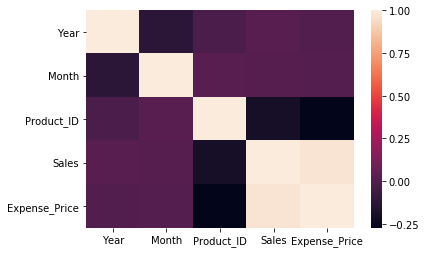

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.heatmap(t.corr())

In [14]:
temp_df=t
t.corr()

,Year,Month,Product_ID,Sales,Expense_Price
Year,1.000000,-0.125730,-0.020647,0.024104,-0.001390
Month,-0.125730,1.000000,0.014924,0.010762,0.005502
Product_ID,-0.020647,0.014924,1.000000,-0.196632,-0.273691
Sales,0.024104,0.010762,-0.196632,1.000000,0.973143
Expense_Price,-0.001390,0.005502,-0.273691,0.973143,1.000000


In [15]:
t=temp_df
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df
for i in ["Country","Product_ID"]:
    t=create_dummies(t,i)
t.columns

Index(['Year', 'Country', 'Month', 'Product_ID', 'Sales', 'Expense_Price',
       'Country_Argentina', 'Country_Belgium', 'Country_Columbia',
       'Country_Denmark', 'Country_England', 'Country_Finland', 'Product_ID_1',
       'Product_ID_2', 'Product_ID_3', 'Product_ID_4', 'Product_ID_5'],
      dtype='object')

In [16]:
def select_features(df):
    all_X = df.drop(["Sales","Country"],axis=1)
    all_y = df["Sales"]
    
    clf = RandomForestRegressor(random_state=2)
    selector = RFECV(clf,cv=40)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(t)

Best Columns 
------------
['Year', 'Month', 'Product_ID', 'Expense_Price', 'Country_Argentina', 'Country_Belgium', 'Country_Columbia', 'Country_Denmark', 'Country_Finland', 'Product_ID_1', 'Product_ID_2', 'Product_ID_3']



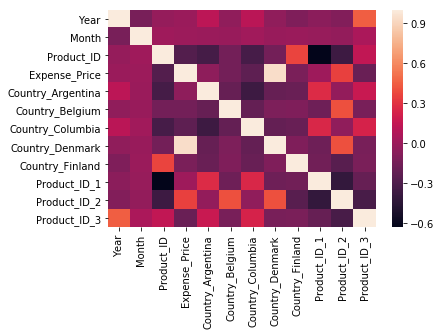

In [17]:
sns.heatmap(t[cols].corr())

In [18]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Sales"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LinearRegression",
            "estimator": LinearRegression(),
            "hyperparameters":
                {
                    "fit_intercept": [True, False],
                    "copy_X": [True, False],
                    "n_jobs": [1,2]
                }
        },
        {
            "name": "RandomForestRegressor",
            "estimator": RandomForestRegressor(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 8, 10],
                    "max_depth": [5, 10 ,12, 14 ,15],
                    "max_features": ["log2", "sqrt","auto"],
                    "min_samples_leaf": [8,10,12],
                    "min_samples_split": [2, 3]

                }
        },
        {
            "name": "ADABoosting",
            "estimator": AdaBoostRegressor(DecisionTreeRegressor(max_depth=12), random_state=100),
            "hyperparameters":
                {
                    "n_estimators": [10,20,44, 50],
                    "loss" : ["linear", "square", "exponential"],
                    "learning_rate":[1,1.1,1.11,1.111,1.2,1.4,1.5]
                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(t,cols)


LinearRegression
----------------
Best Score: 0.9586406777809052
Best Parameters: {'copy_X': True, 'fit_intercept': False, 'n_jobs': 1}

RandomForestRegressor
---------------------
Best Score: 0.9451388161414976
Best Parameters: {'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 8}

ADABoosting
-----------
Best Score: 0.9544278525648017
Best Parameters: {'learning_rate': 1.5, 'loss': 'linear', 'n_estimators': 44}



In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
df = t.sample(frac=1).reset_index(drop=True)
model2=RandomForestRegressor(max_depth= 12, max_features= "auto", min_samples_leaf= 8, min_samples_split= 2,
                            n_estimators= 8)
model2.fit(df[cols][0:300],df["Sales"][0:300])
prediction=model2.predict(df[cols][300:])
mean_absolute_percentage_error(df["Sales"][300:],prediction)

20.5573560669991

In [44]:
df = t.sample(frac=1).reset_index(drop=True)
model4=AdaBoostRegressor(DecisionTreeRegressor(max_depth=12),learning_rate= 1.11, loss= "square", n_estimators= 10)
model4.fit(df[cols][0:300],df["Sales"][0:300])
prediction=model4.predict(df[cols][300:])
mean_absolute_percentage_error(df["Sales"][300:],prediction)

10.049930624351035

In [46]:
t_test=test_df
t_test=pd.merge(test_df,expence_df,how="left",on=["Year","Month","Country","Product_ID"]).drop("Sales",axis=1)
for i in ["Country","Product_ID"]:
    t_test=create_dummies(t_test,i)
t_test.head()

,S_No,Year,Month,Product_ID,Country,Expense_Price,Country_Argentina,Country_Belgium,Country_Columbia,Country_Denmark,Country_England,Country_Finland,Product_ID_1,Product_ID_2,Product_ID_3,Product_ID_4,Product_ID_5
0,79073,2016,4,1,Argentina,8214.875,1,0,0,0,0,0,1,0,0,0,0
1,79074,2016,5,1,Argentina,10777.878,1,0,0,0,0,0,1,0,0,0,0
2,79075,2016,6,1,Argentina,10320.673,1,0,0,0,0,0,1,0,0,0,0
3,79076,2016,7,1,Argentina,7377.587,1,0,0,0,0,0,1,0,0,0,0
4,79077,2016,8,1,Argentina,9805.705,1,0,0,0,0,0,1,0,0,0,0


In [47]:
t_test=t_test.fillna(-1)
t_test.columns

Index(['S_No', 'Year', 'Month', 'Product_ID', 'Country', 'Expense_Price',
       'Country_Argentina', 'Country_Belgium', 'Country_Columbia',
       'Country_Denmark', 'Country_England', 'Country_Finland', 'Product_ID_1',
       'Product_ID_2', 'Product_ID_3', 'Product_ID_4', 'Product_ID_5'],
      dtype='object')

In [48]:
model=AdaBoostRegressor(DecisionTreeRegressor(max_depth=12),learning_rate= 1.11, loss= "square", n_estimators= 10)
model.fit(t[cols],t["Sales"])
prediction=model.predict(t_test[cols])

In [49]:
prediction

array([1.50160500e+07, 3.30687000e+07, 1.50160500e+07, 1.50160500e+07,
       1.50160500e+07, 1.50160500e+07, 1.50160500e+07, 1.50160500e+07,
       1.12140000e+07, 1.47404250e+07, 1.12140000e+07, 1.50160500e+07,
       7.31839878e+06, 7.53539920e+06, 7.45670674e+06, 7.31839878e+06,
       7.31839878e+06, 7.31839878e+06, 7.31839878e+06, 7.31839878e+06,
       7.31839878e+06, 7.53539920e+06, 7.53539920e+06, 6.51716646e+06,
       1.62807750e+07, 1.12140000e+07, 1.73754000e+07, 1.80662680e+06,
       1.80662680e+06, 2.57300498e+06, 2.58782225e+06, 2.58782225e+06,
       2.58782225e+06, 2.58782225e+06, 2.58782225e+06, 4.26323655e+06,
       1.08725928e+06, 1.08725928e+06, 1.08725928e+06, 3.61736909e+06,
       3.31348560e+06, 3.65483412e+06, 3.31348560e+06, 3.31348560e+06,
       3.60284709e+06, 3.31348560e+06, 3.63470510e+06, 3.61736909e+06,
       3.31348560e+06, 3.31348560e+06, 3.93776295e+06, 7.21520000e+06,
       7.21520000e+06, 7.21520000e+06, 7.21520000e+06, 6.63704000e+06,
      

In [50]:
t_test["Sales"]=prediction
t_test.head()

,S_No,Year,Month,Product_ID,Country,Expense_Price,Country_Argentina,Country_Belgium,Country_Columbia,Country_Denmark,Country_England,Country_Finland,Product_ID_1,Product_ID_2,Product_ID_3,Product_ID_4,Product_ID_5,Sales
0,79073,2016,4,1,Argentina,8214.875,1,0,0,0,0,0,1,0,0,0,0,15016050.0
1,79074,2016,5,1,Argentina,10777.878,1,0,0,0,0,0,1,0,0,0,0,33068700.0
2,79075,2016,6,1,Argentina,10320.673,1,0,0,0,0,0,1,0,0,0,0,15016050.0
3,79076,2016,7,1,Argentina,7377.587,1,0,0,0,0,0,1,0,0,0,0,15016050.0
4,79077,2016,8,1,Argentina,9805.705,1,0,0,0,0,0,1,0,0,0,0,15016050.0


In [51]:
yds=t_test[["S_No","Year","Month","Product_ID","Country","Sales"]]
yds.head()

,S_No,Year,Month,Product_ID,Country,Sales
0,79073,2016,4,1,Argentina,15016050.0
1,79074,2016,5,1,Argentina,33068700.0
2,79075,2016,6,1,Argentina,15016050.0
3,79076,2016,7,1,Argentina,15016050.0
4,79077,2016,8,1,Argentina,15016050.0


In [52]:
yds.to_csv("yds_submission2018.csv",index=False)